In [28]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint as odeint
from sklearn.metrics import mean_squared_error

Using device: cuda
Epoch [10/100], Loss: 0.0371
Epoch [20/100], Loss: 0.0310
Epoch [30/100], Loss: 0.0245
Epoch [40/100], Loss: 0.0172
Epoch [50/100], Loss: 0.0094
Epoch [60/100], Loss: 0.0024
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0002
Epoch [10/150], Loss: 0.0187
Epoch [20/150], Loss: 0.0105
Epoch [30/150], Loss: 0.0040
Epoch [40/150], Loss: 0.0006
Epoch [50/150], Loss: 0.0001
Epoch [60/150], Loss: 0.0002
Epoch [70/150], Loss: 0.0000
Epoch [80/150], Loss: 0.0000
Epoch [90/150], Loss: 0.0000
Epoch [100/150], Loss: 0.0000
Epoch [110/150], Loss: 0.0000
Epoch [120/150], Loss: 0.0000
Epoch [130/150], Loss: 0.0000
Epoch [140/150], Loss: 0.0000
Epoch [150/150], Loss: 0.0000
Model 1 MSE: 0.0025
Model 2 MSE: 0.0015


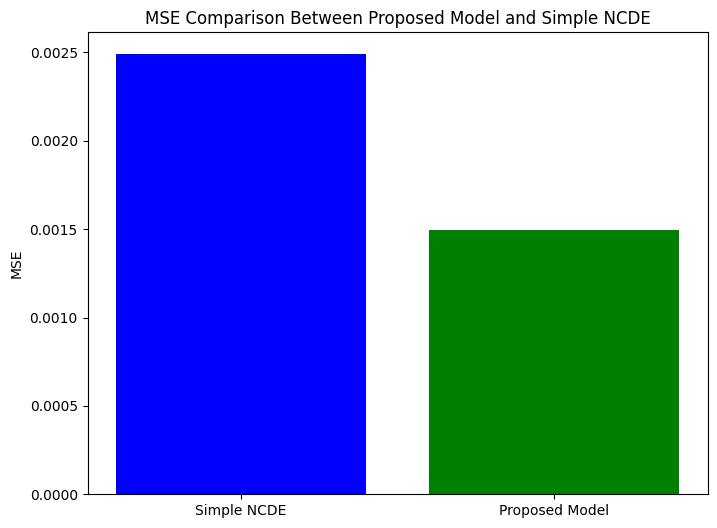

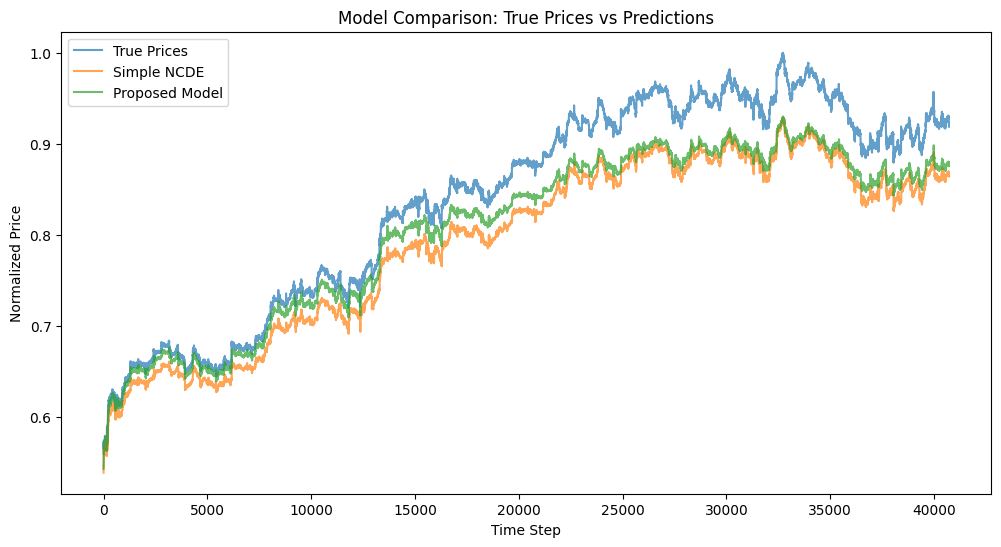

In [ ]:
file_path = "NIFTY HEALTHCARE_minute.csv"
data = pd.read_csv(file_path)

data['datetime'] = pd.to_datetime(data['date'])
data = data.sort_values('datetime')

features = ['open', 'high', 'low', 'close']
data = data[features]

data_norm = (data - data.min()) / (data.max() - data.min())

def create_sequences(data, window_size=10):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size]) 
        targets.append(data[i + window_size, -1])  # Close price as target
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

window_size = 10
X, y = create_sequences(data_norm.to_numpy(), window_size)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

class NeuralCDEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(NeuralCDEFunc, self).__init__()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, t, h):
        return self.relu(self.linear(h))

class LearnablePath(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LearnablePath, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class NeuralCDEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralCDEModel, self).__init__()
        self.func = NeuralCDEFunc(hidden_dim)
        self.path = LearnablePath(input_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, times, data):
        coeffs = self.path(data)
        h0 = coeffs[:, 0]  # Initial hidden state
        h_t = odeint(self.func, h0, times)
        out = self.linear_out(h_t[-1])  # Final hidden state
        return out

class NeuralFlow(nn.Module):
    def __init__(self, hidden_dim, time_dim=1):
        super(NeuralFlow, self).__init__()
        self.fc1 = nn.Linear(hidden_dim + time_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, t, h):
        t_expanded = t.expand_as(h[:, :1])
        input_combined = torch.cat([h, t_expanded], dim=-1)
        return self.relu(self.fc2(self.relu(self.fc1(input_combined))))

class NeuralCDEModelWithFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralCDEModelWithFlow, self).__init__()
        self.flow = NeuralFlow(hidden_dim)
        self.path = LearnablePath(input_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, times, data):
        coeffs = self.path(data)
        h0 = coeffs[:, 0]  # Initial hidden state
        h_t = odeint(self.flow, h0, times)
        out = self.linear_out(h_t[-1])  # Final hidden state
        return out

input_dim = X.shape[2]
hidden_dim = 16
output_dim = 1
model_1 = NeuralCDEModel(input_dim, hidden_dim, output_dim).to(device) 
model_2 = NeuralCDEModelWithFlow(input_dim, hidden_dim, output_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model_1.train()
    optimizer.zero_grad()

    times = torch.linspace(0, 1, steps=X_train.size(1)).to(device) 
    output = model_1(times, X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

epochs = 150
for epoch in range(epochs):
    model_2.train()
    optimizer.zero_grad()

    times = torch.linspace(0, 1, steps=X_train.size(1)).to(device) 
    output = model_2(times, X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


model_1.eval()
times_1 = torch.linspace(0, 1, steps=X_test.size(1)).to(device)
predictions_1 = model_1(times_1, X_test).cpu().detach().numpy()

model_2.eval()
times_2 = torch.linspace(0, 1, steps=X_test.size(1)).to(device)
predictions_2 = model_2(times_2, X_test).cpu().detach().numpy()

y_test_cpu = y_test.cpu().numpy()

mse_1 = mean_squared_error(y_test_cpu, predictions_1)
mse_2 = mean_squared_error(y_test_cpu, predictions_2)

print(f"Model 1 MSE: {mse_1:.4f}")
print(f"Model 2 MSE: {mse_2:.4f}")

plt.figure(figsize=(8, 6))
plt.bar(['Simple NCDE', 'Proposed Model'], [mse_1, mse_2], color=['blue', 'green'])
plt.ylabel('MSE')
plt.title('MSE Comparison Between Proposed Model and Simple NCDE')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_cpu, label="True Prices", alpha=0.7)
plt.plot(predictions_1, label="Simple NCDE", alpha=0.7)
plt.plot(predictions_2, label="Proposed Model", alpha=0.7)
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.title('Model Comparison: True Prices vs Predictions')
plt.show()